# Introduction

I will explore the problem in following stages:

1.  **Hypothesis Generation** – understanding the problem better by brainstorming possible factors that can impact the outcome
2.  **Data Exploration** – looking at categorical and continuous feature summaries and making inferences about the data.
3.  **Data Cleaning** – imputing missing values in the data and checking for outliers
4.  **Feature Engineering** – modifying existing variables and creating new ones for analysis
5.  **Model Building** – making predictive models on the data


## 1. Hypothesis Generation

This involves understanding the problem and making some hypothesis about what could potentially have a good impact on the outcome. This is done BEFORE looking at the data, and we end up creating a laundry list of the different analysis which we can potentially perform if data is available.

### The Problem Statement

Understanding the problem statement is the first and foremost step:

> In this competition, you will forecast the demand of a product for a given week, at a particular store. The dataset you are given consists of 9 weeks of sales transactions in Mexico. Every week, there are delivery trucks that deliver products to the vendors. Each transaction consists of sales and returns. Returns are the products that are unsold and expired. The demand for a product in a certain week is defined as the sales this week subtracted by the return next week.

So the idea is to find out the demand of a product (sales - returns) per client, and store which impacts the sales of a product. Let’s think about some of the analysis that can be done and come up with certain hypothesis.

### The Hypotheses

I came up with the following hypothesis while thinking about the problem. Since we’re talking about stores and products, lets make different sets for each.

**Store/Client Level Hypotheses:**

1.  **Town type:** Stores located in urban or Tier 1 towns should have higher sales because of the higher income levels of people there.
2.  **Population Density:** Stores located in densely populated areas should have higher sales because of more demand.
3.  **Store Capacity:** Stores which are very big in size should have higher sales as they act like one-stop-shops and people would prefer getting everything from one place
4.  **Competitors:** Stores having similar establishments nearby should have less sales because of more competition.
5.  **Marketing:** Stores which have a good marketing division should have higher sales as it will be able to attract customers through the right offers and advertising.
6.  **Location:** Stores located within popular marketplaces should have higher sales because of better access to customers.
7.  **Customer Behavior:** Stores keeping the right set of products to meet the local needs of customers will have higher sales.
8.  **Ambiance:** Stores which are well-maintained and managed by polite and humble people are expected to have higher footfall and thus higher sales.
9.  **Season:** Store should sell more after customer's pay day: after 15th or 30th of the month

**Product Level Hypotheses:**

1.  **Brand:** Branded products should have higher sales because of higher trust in the customer.
2.  **Packaging:** Products with good packaging can attract customers and sell more.
3.  **Utility:** Daily use products should have a higher tendency to sell as compared to the specific use products.
4.  **Display Area:** Products which are given bigger shelves in the store are likely to catch attention first and sell more.
5.  **Visibility in Store:** The location of product in a store will impact sales. Ones which are right at entrance will catch the eye of customer first rather than the ones in back.
6.  **Advertising:** Better advertising of products in the store will should higher sales in most cases.
7.  **Promotional Offers:** Products accompanied with attractive offers and discounts will sell more.


Lets move on to the data exploration where we will have a look at the data in detail.

## 2\. Data Exploration

I’ll be performing some basic data exploration here and come up with some inferences about the data.

The first step is to look at the data and try to identify the information which we hypothesized vs the available data. A comparison between the data dictionary on the competition page and out hypotheses is shown below:

![Image of Variables vs Hypothesis](files/../input-data/Variables_vs_Hyphotesis.png)

We can summarize the findings as:

** 9 Features Hypothesized but not found in actual data. **

** 5 Features Hypothesized as well as present in the data **

** 3 Features present in the data but not hypothesized. **


We find features which we hypothesized, but data doesn’t carry and vice versa. We should look for open source data to fill the gaps if possible. Let’s start by loading the required libraries and data. 

In [31]:
import pandas as pd
import numpy as np
import time
import csv
import boto # to download from AWS S3 buckets
import pickle
import warnings
warnings.filterwarnings("ignore")

_start_time = time.time()

# define a easy timing function to use going forward
def tic():
    global _start_time 
    _start_time = time.time()

def tac():
    t_sec = round(time.time() - _start_time)
    (t_min, t_sec) = divmod(t_sec,60)
    (t_hour,t_min) = divmod(t_min,60) 
    print('Time passed: {}hour:{}min:{}sec'.format(t_hour,t_min,t_sec))
    
# utility function- display large dataframes in an html iframe
def df_display(df, lines=500):
    txt = ("<iframe " +
           "srcdoc='" + df.head(lines).to_html() + "' " +
           "width=1000 height=500>" +
           "</iframe>")

    return IPython.display.HTML(txt)


In [111]:
#Let's define variables that will define the behaviour of the whole script
s3_path = 'http://bbts-kaggle.s3.amazonaws.com/bimbo/Pablo/'
use_validation=True
scale_numericals=True
onehot_categoricals=False
lag = 4
num_clusters_cliente = 4000
shifted_target = True
trimmed = True

In [8]:
#Read files:
tic()
train = pd.read_csv(s3_path +'train.csv',
                           dtype  = {'Semana': 'int8',
                                     'Producto_ID':'int32',
                                     'Cliente_ID':'int32',
                                     'Agencia_ID':'uint16',
                                     'Canal_ID':'int8',
                                     'Ruta_SAK':'int32',
                                     'Venta_hoy':'float32',
                                     'Venta_uni_hoy': 'int8',
                                     'Dev_uni_proxima':'int8',
                                     'Dev_proxima':'float32',
                                     'Demanda_uni_equil':'int32'})
test = pd.read_csv(s3_path +'test.csv',
                           dtype  = {'Semana': 'int8',
                                     'Producto_ID':'int32',
                                     'Cliente_ID':'int32',
                                     'Agencia_ID':'uint16',
                                     'Canal_ID':'int8',
                                     'Ruta_SAK':'int32'})
tac()

Time passed: 0hour:2min:9sec


In [9]:
# remove unnecessary fields in training data
train.drop(['Venta_uni_hoy', 'Venta_hoy','Dev_uni_proxima', 'Dev_proxima'], axis=1, inplace=True)

In [10]:
#Since test dataframe is not the same as train dataframe, we make them equal by removing and adding columns
train.insert(0, 'id', np.nan)
test.insert(7, 'Demanda_uni_equil', np.nan)

Now, probably one of the most important steps is to split the train set in train and validation. And never touch the validation set for any feature engineering, and to treat it just like the unseen test set

In [11]:
if (use_validation):
    tic()
    val = train[train.Semana > 8] # Weeks 9
    train = train[train.Semana <=8] # Weeks 7,8
    tac()
    

Time passed: 0hour:0min:3sec


It is a good idea to combine both train and test data sets into one, perform feature engineering and then divide them later again. This saves the trouble of performing the same steps twice on test and train. Lets combine them into a dataframe ‘data’ with a ‘source’ column specifying where each observation belongs.

In [12]:
tic()
train['source']='train'
if (use_validation): 
    val['source']='val'
test['source']='test'

if (use_validation): 
    data = pd.concat([train,val,test],ignore_index=True)
    print (train.shape, val.shape, test.shape, data.shape)
else:
    data = pd.concat([train,test],ignore_index=True)
    print (train.shape, test.shape, data.shape)
tac()


(63771751, 9) (10408713, 9) (6999251, 9) (81179715, 9)
Time passed: 0hour:0min:13sec


In [13]:
#We must now remove the target column=Demanda_uni_equil from the val dataset and keep it away
data['ix'] = data.index # assign and id column to later at the end map the val_targets back to the dataframe
if (use_validation):
    val_target = data[['ix','Demanda_uni_equil']].loc[data['source']=='val'] #save the val targets on a different dataframe
    data.loc[data['source']=='val','Demanda_uni_equil'] =  np.nan # replaces val targets with nan for feature engineering

Thus we can see that data has same #columns but rows equivalent to both test and train. Lets start by checking which columns contain missing values. (takes aprox 30 mins to run!)

In [14]:
#data.apply(lambda x: sum(x.isnull()))

There doesn't seem to be any missing values (other than the NaN we set on the test and train sets).

Lets look at some basic statistics for numerical variables.

In [15]:
#data.describe()

Some observations:

   Looking at Demanda_uni_equil (our target), or the amount of product sold per week, we find interesting things:
   
   **1)** The average is 7.22, so in average there is 7 units per week per store sold.
   
   **2)** Looking at the max of 5000, it looks very far fro the mean (3 orders of magnitude), so we must check for an outlier here or a store that is crazy different from the rest.
   
   **3)** Same behaviour we find on Dev_uni_proxima, Venta_hoy and Venta_uni_hoy
   
Looking at the nice data analysis made in R by Faviens, here: https://www.kaggle.com/fabienvs/grupo-bimbo-inventory-demand/notebook-8a62eda039a3b0b944cf/notebook we corroborate the outlier(s):
There is a massive client: Puebla Remision
   
![Image of size of Customers]( https://www.kaggle.io/svf/267812/783a24d1dd546819a44914f996b249e8/__results___files/figure-html/unnamed-chunk-16-1.png)
   

Moving to nominal (categorical) variable, lets have a look at the number of unique values in each of them.

In [16]:
#data.apply(lambda x: len(x.unique()))

So, in train and test sets, we have 552 Agencies(depots), 890k clients (we might have some repeated clients due to typos when enterind data), 1833 products (we might have some repeated products here based on typos) and 3620 routes

In [17]:
# Let's see how many records we have per week
for i in range(3,12):
    print("Semana"+repr(i)+" =\t" + repr(data[data["Semana"]==i].Semana.count()))

Semana3 =	11165207
Semana4 =	11009593
Semana5 =	10615397
Semana6 =	10191837
Semana7 =	10382849
Semana8 =	10406868
Semana9 =	10408713
Semana10 =	3538385
Semana11 =	3460866


As stated in the Kaggle competition - Week 10 and 11 is sampled down aprox 70%. According to Kaggle, this was done so the scoring of candidates didn't take extremely long.

## 3\. Data Cleaning

This step involves imputing missing values and treating outliers. As we saw before, there are no missing values. Regarding outliers, there seem to be an obvious one, but we are going to see later on if its necessary to treat it differently.

My initial reaction would be to see if anything with the word REMISION is on the test set. if not, then delete it. See this discussion: https://www.kaggle.com/c/grupo-bimbo-inventory-demand/forums/t/22037/puebla-remission/126053

In [18]:
#Let's find out who are the clients with the word REMISION on it
client_name = pd.read_csv('./input-data/cliente_tabla.csv')
cliente_id_name_train = pd.merge(train,client_name, on='Cliente_ID')
cliente_id_name_test = pd.merge(test,client_name, on='Cliente_ID')

In [19]:
cliente_id_name_train.head()

,id,Semana,Agencia_ID,Canal_ID,Ruta_SAK,Cliente_ID,Producto_ID,Demanda_uni_equil,source,NombreCliente
0,NaN,3,1110,7,3301,15766,1212,3,train,PUESTO DE PERIODICOS LAZARO
1,NaN,3,1110,7,3301,15766,1216,4,train,PUESTO DE PERIODICOS LAZARO
2,NaN,3,1110,7,3301,15766,1238,4,train,PUESTO DE PERIODICOS LAZARO
3,NaN,3,1110,7,3301,15766,1240,4,train,PUESTO DE PERIODICOS LAZARO
4,NaN,3,1110,7,3301,15766,1242,3,train,PUESTO DE PERIODICOS LAZARO


In [20]:
cliente_id_name_train[cliente_id_name_train.NombreCliente.str.contains('REMISION')].count()

id                        0
Semana               119552
Agencia_ID           119552
Canal_ID             119552
Ruta_SAK             119552
Cliente_ID           119552
Producto_ID          119552
Demanda_uni_equil    119552
source               119552
NombreCliente        119552
dtype: int64

As we can see above, the word "REMISION" shows up 140k times on the train set. Let's see the test set:

In [21]:
cliente_id_name_test[cliente_id_name_test.NombreCliente.str.contains('REMISION')].count()

id                   12842
Semana               12842
Agencia_ID           12842
Canal_ID             12842
Ruta_SAK             12842
Cliente_ID           12842
Producto_ID          12842
Demanda_uni_equil        0
source               12842
NombreCliente        12842
dtype: int64

12k rows shows up the word REMISION on the test set. This implies that it has to be predicted as well. We cannot eliminate it.

## 4\. Feature Engineering

We explored some nuances in the data in the data exploration section. Lets move on to resolving them and making our data ready for analysis. We will also create some new variables using the existing ones in this section.

In [22]:
#First thing we need to do is to transform our target ( Demanda_uni_equil) to log(1 + demand) - this makes sense since we're 
#trying to minimize rmsle vs the mean which minimizes rmse. At the end of the modeling (for submission) we need to reverse it 
#by applying expm1(x)

if(shifted_target):
    data['log_target'] = 1.0069990*np.log1p(data["Demanda_uni_equil"] + 0.011599)-0.011599
else:
    data['log_target'] = np.log1p(data["Demanda_uni_equil"])

In [23]:
data.head()

,id,Semana,Agencia_ID,Canal_ID,Ruta_SAK,Cliente_ID,Producto_ID,Demanda_uni_equil,source,ix,log_target
0,NaN,3,1110,7,3301,15766,1212,3.0,train,0,1.387314
1,NaN,3,1110,7,3301,15766,1216,4.0,train,1,1.611437
2,NaN,3,1110,7,3301,15766,1238,4.0,train,2,1.611437
3,NaN,3,1110,7,3301,15766,1240,4.0,train,3,1.611437
4,NaN,3,1110,7,3301,15766,1242,3.0,train,4,1.387314


In [24]:
#Let's also create all the grouping dataframes we are going to need 
tic()

global_mean = data['log_target'].mean()
prod_mean = data.groupby('Producto_ID').agg({'log_target': 'mean' })
client_mean = data.groupby('Cliente_ID').agg({'log_target': 'mean' })
prod_client_mean = data.groupby(['Producto_ID', 'Cliente_ID']).agg({'log_target': 'mean' })
semana_client_prod_mean = data.groupby(['Semana','Cliente_ID','Producto_ID']).agg({'log_target': 'mean'})
ruta_cliente_prod_mean = data.groupby(['Ruta_SAK','Cliente_ID','Producto_ID']).agg({'log_target': 'mean'})

tac()

Time passed: 0hour:2min:2sec


###  Feature 1:  Mean of pairs cliente-producto

First and foremost, we want to create the average (mean) demand per each pair of cliente-producto, if we don't have the demand of the pair,  we calculate the average demand of the product, and if we don't have the demand of the product(new introduced product that week), then we calculate the average demand of the client, and if we don't have any (new client and  on that week), we default to the global

In [25]:
tic()
prod_mean_dict = prod_mean.to_dict()
client_mean_dict = client_mean.to_dict()
prod_client_mean_dict = prod_client_mean.to_dict()
tac()

Time passed: 0hour:0min:24sec


In [26]:
def gen_pairs_mean_feature(key):
    key = tuple(key)
    product = key[0]
    client = key[1]
    
    val = prod_client_mean_dict['log_target'][(product,client)]
    if np.isnan(val):
        val = prod_mean_dict['log_target'][(product)]
        if np.isnan(val):
            val = client_mean_dict['log_target'][(client)]
            if np.isnan(val):
                val = global_mean
            
    return val

In [27]:
tic()
data['pairs_mean'] = data[['Producto_ID', 'Cliente_ID']].apply(lambda x:gen_pairs_mean_feature(x), axis=1)
tac()

Time passed: 0hour:39min:4sec


In [28]:
data.head()

,id,Semana,Agencia_ID,Canal_ID,Ruta_SAK,Cliente_ID,Producto_ID,Demanda_uni_equil,source,ix,log_target,pairs_mean
0,NaN,3,1110,7,3301,15766,1212,3.0,train,0,1.387314,1.601208
1,NaN,3,1110,7,3301,15766,1216,4.0,train,1,1.611437,1.280466
2,NaN,3,1110,7,3301,15766,1238,4.0,train,2,1.611437,1.212577
3,NaN,3,1110,7,3301,15766,1240,4.0,train,3,1.611437,1.749045
4,NaN,3,1110,7,3301,15766,1242,3.0,train,4,1.387314,1.175224


In [29]:
#Saving the work
tic()
if (shifted_target):
    output = open('./input-data/Data_pairs_mean_shifted.pkl', 'wb')
else:
    output = open('./input-data/Data_pairs_mean.pkl', 'wb')
pickle.dump(data, output)
tac()

Time passed: 0hour:0min:35sec


### Feature 2: Lags - Demand per client-product pair for prior weeks
Based on this blog: http://blog.nycdatascience.com/student-works/predicting-demand-historical-sales-data-grupo-bimbo-kaggle-competition/

As this script said: https://www.kaggle.com/bpavlyshenko/grupo-bimbo-inventory-demand/bimbo-xgboost-r-script-lb-0-457/code
It is important to know what were the previous weeks sales. If the previous week, too many products were supplied and they were not sold, the next week this product amount, supplied to the same store, will be decreased. So it is very important to included lag values of target variable as a feature to predict the next sales.

In [112]:
#Retrieve the saved work
tic()
if (shifted_target):
    pkl_file = open('./input-data/Data_pairs_mean_shifted.pkl', 'rb')
else:
    pkl_file = open('./input-data/Data_pairs_mean.pkl', 'rb')
data = pickle.load(pkl_file)
tac()

Time passed: 0hour:0min:18sec


In [113]:
df = semana_client_prod_mean.reset_index() # we convert the index to columns for later use

In [114]:
df.head()

,Semana,Cliente_ID,Producto_ID,log_target
0,3,26,1182,3.703391
1,3,26,4767,3.776197
2,3,26,31393,3.054788
3,3,26,31690,3.776197
4,3,26,32962,1.387314


In [115]:
# Let's see how many records we have per week on the semana_cliente_Producto groups vs the raw dataset
for i in range(3,12):
    print("Semana"+repr(i)+" =\t" + repr(data[data["Semana"]==i].Semana.count())+ " (raw)\t" +
            repr(df[df["Semana"]==i].Semana.count()) + " (group)\t" +  
            repr(data[data["Semana"]==i].Semana.count() - df[df["Semana"]==i].Semana.count()) + " (diff)"
         )

Semana3 =	11165207 (raw)	11140707 (group)	24500 (diff)
Semana4 =	11009593 (raw)	10985436 (group)	24157 (diff)
Semana5 =	10615397 (raw)	10591171 (group)	24226 (diff)
Semana6 =	10191837 (raw)	10167946 (group)	23891 (diff)
Semana7 =	10382849 (raw)	10359111 (group)	23738 (diff)
Semana8 =	10406868 (raw)	10383302 (group)	23566 (diff)
Semana9 =	10408713 (raw)	10385350 (group)	23363 (diff)
Semana10 =	3538385 (raw)	3531921 (group)	6464 (diff)
Semana11 =	3460866 (raw)	3454394 (group)	6472 (diff)


As we can see above, there are repeated combinations of client-product on each week.

In [116]:
#Before we start adding lags and removing rows, let's see the size of our dataset
size_data = data.memory_usage().sum()
print(size_data)

5195501840


In [117]:
#here we add the number of lags we want
tic()

for i in range(1,lag+1):
    df['Semana'] += 1
    df.rename(columns={df.columns[3]: 'Log_Target_mean_lag%d' %(i)}, inplace=True)
    data = pd.merge(data,df, how = 'left', on = ['Semana','Cliente_ID','Producto_ID']) #here we add the lag to the dataset
    data['Log_Target_mean_lag%d' %(i)].fillna(0, inplace=True) # we replace the client-product log mean NaN/Not found on the week before with ZERO
    data = data[data.Semana != i+2] # here we delete the week rows we dont have lags for
   
tac()

Time passed: 0hour:5min:21sec


In [118]:
#Let's see how many NaN or Nulls we have
#data.apply(lambda x: sum(x.isnull()))

The above looks correct! the only NaN shown are the variables that are not avaibable on the val or test set, everyting else looks good


In [119]:
# Let's see how many records we have per week and make sure we didn't delete any data from our important weeks
for i in range(3,12):
    print("Semana"+repr(i)+" =\t" + repr(data[data["Semana"]==i].Semana.count()))

Semana3 =	0
Semana4 =	0
Semana5 =	0
Semana6 =	0
Semana7 =	10382849
Semana8 =	10406868
Semana9 =	10408713
Semana10 =	3538385
Semana11 =	3460866


The above looks correct! we deleted the week rows we don't have lags for, and we kept the original amount of rows for the remaining weeks.

In [120]:
#Now let's see how much was the data set size reduced/increased
new_size_data = data.memory_usage().sum()
print("Dataset size changed in " + repr((new_size_data - size_data )*100/new_size_data) + "%")

Dataset size changed in -30.78476795891997%


Good! the data set was greatly reduced (this means faster modeling)

In [121]:
data.head()

,id,Semana,Agencia_ID,Canal_ID,Ruta_SAK,Cliente_ID,Producto_ID,Demanda_uni_equil,source,ix,log_target,pairs_mean,Log_Target_mean_lag1,Log_Target_mean_lag2,Log_Target_mean_lag3,Log_Target_mean_lag4
10191837,NaN,7,1110,7,3301,15766,1216,2.0,train,42982034,1.098588,1.280466,0.692223,1.387314,1.098588,1.611437
10191838,NaN,7,1110,7,3301,15766,1238,2.0,train,42982035,1.098588,1.212577,1.098588,0.692223,1.387314,1.611437
10191839,NaN,7,1110,7,3301,15766,1240,8.0,train,42982036,2.202301,1.749045,0.000000,0.000000,2.083856,1.611437
10191840,NaN,7,1110,7,3301,15766,1242,2.0,train,42982037,1.098588,1.175224,1.387314,1.098588,1.387314,1.387314
10191841,NaN,7,1110,7,3301,15766,1250,14.0,train,42982038,2.716183,1.832495,0.692223,2.202301,1.387314,1.794646


###  Feature 4:  Calculates de sum of prior weeks Log mean Demands

In [122]:
#We want to sum the lags up until week 9, this means that we need to sum lag2 and up.
data['Lags_sum'] = 0
for i in range(1,lag+1):
    data['Lags_sum'] += data['Log_Target_mean_lag%d' %(i)]

In [123]:
data.head()

,id,Semana,Agencia_ID,Canal_ID,Ruta_SAK,Cliente_ID,Producto_ID,Demanda_uni_equil,source,ix,log_target,pairs_mean,Log_Target_mean_lag1,Log_Target_mean_lag2,Log_Target_mean_lag3,Log_Target_mean_lag4,Lags_sum
10191837,NaN,7,1110,7,3301,15766,1216,2.0,train,42982034,1.098588,1.280466,0.692223,1.387314,1.098588,1.611437,4.789562
10191838,NaN,7,1110,7,3301,15766,1238,2.0,train,42982035,1.098588,1.212577,1.098588,0.692223,1.387314,1.611437,4.789562
10191839,NaN,7,1110,7,3301,15766,1240,8.0,train,42982036,2.202301,1.749045,0.000000,0.000000,2.083856,1.611437,3.695292
10191840,NaN,7,1110,7,3301,15766,1242,2.0,train,42982037,1.098588,1.175224,1.387314,1.098588,1.387314,1.387314,5.260530
10191841,NaN,7,1110,7,3301,15766,1250,14.0,train,42982038,2.716183,1.832495,0.692223,2.202301,1.387314,1.794646,6.076483


### Feature 5: Create a broad category of Brand of item (brand hypothesis)
Let's preprocess products a little bit. I borrowed some of the preprocessing from here: https://www.kaggle.com/vykhand/grupo-bimbo-inventory-demand/exploring-products

In [124]:
products  =  pd.read_csv("input-data/producto_tabla.csv")
products  =  pd.read_csv("input-data/producto_tabla.csv")
#products['short_name'] = products.NombreProducto.str.extract('^(\D*)', expand=False)#python 2.7
products['short_name'] = products.NombreProducto.str.extract('^(\D*)')#python 3.0
#products['brand'] = products.NombreProducto.str.extract('^.+\s(\D+) \d+$', expand=False)
products['brand'] = products.NombreProducto.str.extract('^.+\s(\D+) \d+$')
#w = products.NombreProducto.str.extract('(\d+)(Kg|g)', expand=True)
w = products.NombreProducto.str.extract('(\d+)(Kg|g)')
products['weight'] = w[0].astype('float')*w[1].map({'Kg':1000, 'g':1})
#products['pieces'] =  products.NombreProducto.str.extract('(\d+)p ', expand=False).astype('float')
products['pieces'] =  products.NombreProducto.str.extract('(\d+)p ').astype('float')
products.head()

,Producto_ID,NombreProducto,short_name,brand,weight,pieces
0,0,NO IDENTIFICADO 0,NO IDENTIFICADO,IDENTIFICADO,NaN,NaN
1,9,Capuccino Moka 750g NES 9,Capuccino Moka,NES,750.0,NaN
2,41,Bimbollos Ext sAjonjoli 6p 480g BIM 41,Bimbollos Ext sAjonjoli,BIM,480.0,6.0
3,53,Burritos Sincro 170g CU LON 53,Burritos Sincro,LON,170.0,NaN
4,72,Div Tira Mini Doradita 4p 45g TR 72,Div Tira Mini Doradita,TR,45.0,4.0


In [125]:
products.tail()

,Producto_ID,NombreProducto,short_name,brand,weight,pieces
2587,49992,Tostado Integral 180g MTA WON 49992,Tostado Integral,WON,180.0,NaN
2588,49993,Tostado Integral 180g TAB WON 49993,Tostado Integral,WON,180.0,NaN
2589,49994,Tostado Int 0pct Grasa Azuc 200g WON 49994,Tostado Int,WON,200.0,NaN
2590,49996,Tostado Int 0pct Grasa Azuc 200g MTA WON 49996,Tostado Int,WON,200.0,NaN
2591,49997,Tostado Int 0pct Grasa Azuc 200g TAB WON 49997,Tostado Int,WON,200.0,NaN


In [126]:
products.brand.value_counts()

BIM             679
MLA             657
TR              257
LAR             182
GBI             130
WON             117
DH               95
LON              83
SAN              66
MR               64
ORO              44
CC               33
SL               32
BAR              31
SUA              20
RIC              20
MP               10
SUN               9
JMX               8
SKD               7
MCM               5
COR               5
THO               4
NAI               4
NES               3
TRI               3
KOD               2
BRL               2
CHK               2
PUL               2
MSK               2
AM                1
NEC               1
VER               1
AV                1
CAR               1
DIF               1
EMB               1
MTB               1
LC                1
IDENTIFICADO      1
GV                1
VR                1
BRE               1
Name: brand, dtype: int64

In [127]:
products.brand.nunique()

44

In [128]:
products_id_brand  = products[['Producto_ID', 'brand']].copy()

In [129]:
data = pd.merge(data, products_id_brand, on='Producto_ID')

In [130]:
data.head()

,id,Semana,Agencia_ID,Canal_ID,Ruta_SAK,Cliente_ID,Producto_ID,Demanda_uni_equil,source,ix,log_target,pairs_mean,Log_Target_mean_lag1,Log_Target_mean_lag2,Log_Target_mean_lag3,Log_Target_mean_lag4,Lags_sum,brand
0,NaN,7,1110,7,3301,15766,1216,2.0,train,42982034,1.098588,1.280466,0.692223,1.387314,1.098588,1.611437,4.789562,BIM
1,NaN,7,1110,7,3301,988589,1216,1.0,train,42982209,0.692223,0.692223,0.000000,0.000000,0.000000,0.000000,0.000000,BIM
2,NaN,7,1110,7,3301,1255667,1216,4.0,train,42982269,1.611437,1.499375,0.000000,0.000000,1.387314,1.387314,2.774628,BIM
3,NaN,7,1110,7,3301,1307034,1216,1.0,train,42982289,0.692223,0.793814,0.000000,0.000000,1.098588,0.692223,1.790811,BIM
4,NaN,7,1110,7,3301,1603500,1216,1.0,train,42982338,0.692223,0.912514,0.692223,1.387314,1.098588,0.000000,3.178125,BIM


### Feature 6: Create clusters of Products (utility hypothesis) - ramdonly pick 30 clusters

In [131]:
#Read files:
product_clusters = pd.read_csv('input-data/producto_clusters.csv')

In [132]:
product_clusters.tail()

,Producto_ID,NombreProducto,product_shortname,cluster
2586,49992,Tostado Integral 180g MTA WON 49992,Tostado Integral 180g,4
2587,49993,Tostado Integral 180g TAB WON 49993,Tostado Integral 180g,4
2588,49994,Tostado Int 0pct Grasa Azuc 200g WON 49994,Tostado Int 0pct Grasa Azuc 200g,4
2589,49996,Tostado Int 0pct Grasa Azuc 200g MTA WON 49996,Tostado Int 0pct Grasa Azuc 200g,4
2590,49997,Tostado Int 0pct Grasa Azuc 200g TAB WON 49997,Tostado Int 0pct Grasa Azuc 200g,4


In [133]:
print (product_clusters["cluster"].value_counts())

1     204
14    137
10    136
11    124
4     118
13    109
23    103
24    101
19     99
17     93
16     89
8      88
25     85
30     81
22     78
20     75
15     73
9      73
27     71
5      70
2      68
6      65
3      63
26     62
7      61
28     60
12     60
18     59
29     53
21     33
Name: cluster, dtype: int64


In [134]:
products_id_clusters = product_clusters[['Producto_ID', 'cluster']].copy()
products_id_clusters.rename(columns={'cluster': 'prodtype_cluster'}, inplace=True)

In [135]:
products_id_clusters.tail()

,Producto_ID,prodtype_cluster
2586,49992,4
2587,49993,4
2588,49994,4
2589,49996,4
2590,49997,4


In [136]:
data = pd.merge(data, products_id_clusters, on='Producto_ID')

In [137]:
data.head()

,id,Semana,Agencia_ID,Canal_ID,Ruta_SAK,Cliente_ID,Producto_ID,Demanda_uni_equil,source,ix,log_target,pairs_mean,Log_Target_mean_lag1,Log_Target_mean_lag2,Log_Target_mean_lag3,Log_Target_mean_lag4,Lags_sum,brand,prodtype_cluster
0,NaN,7,1110,7,3301,15766,1216,2.0,train,42982034,1.098588,1.280466,0.692223,1.387314,1.098588,1.611437,4.789562,BIM,2
1,NaN,7,1110,7,3301,988589,1216,1.0,train,42982209,0.692223,0.692223,0.000000,0.000000,0.000000,0.000000,0.000000,BIM,2
2,NaN,7,1110,7,3301,1255667,1216,4.0,train,42982269,1.611437,1.499375,0.000000,0.000000,1.387314,1.387314,2.774628,BIM,2
3,NaN,7,1110,7,3301,1307034,1216,1.0,train,42982289,0.692223,0.793814,0.000000,0.000000,1.098588,0.692223,1.790811,BIM,2
4,NaN,7,1110,7,3301,1603500,1216,1.0,train,42982338,0.692223,0.912514,0.692223,1.387314,1.098588,0.000000,3.178125,BIM,2


### Feature 7: Create a category of Size of store based on Number of Agencies and Routes and Sales Channels that serve the store

In [138]:
#Determine pivot table
Rutas_per_store = data.pivot_table(values=["Ruta_SAK"], index=["Cliente_ID"], aggfunc=pd.Series.nunique)

In [139]:
Rutas_per_store.describe()

,Ruta_SAK
count,858290.000000
mean,2.426705
std,1.411257
min,1.000000
25%,1.000000
50%,2.000000
75%,3.000000
max,47.000000


In [140]:
#Agencies_per_store = data.pivot_table(values=["Agencia_ID"], index=["Cliente_ID"], aggfunc=pd.Series.nunique)

In [141]:
#Agencies_per_store.describe()

In [142]:
#Canals_per_store = data.pivot_table(values=["Canal_ID"], index=["Cliente_ID"], aggfunc=pd.Series.nunique)

In [143]:
#Canals_per_store.describe()

It doesn't look that we can Bin on Canal_ID or Agencia_ID since they are not at least semi evenly ditributed, but it does look like Ruta_SAK is a good option based on the percentiles distribution"

In [144]:
Rutas_per_store.rename(columns={'Ruta_SAK': 'Qty_Ruta_SAK'}, inplace=True)

In [145]:
#Mergin Routa_Sak's per client to data df
data = pd.merge(data,Rutas_per_store,right_index=True, left_on='Cliente_ID')

In [146]:
data.tail()

,id,Semana,Agencia_ID,Canal_ID,Ruta_SAK,Cliente_ID,Producto_ID,Demanda_uni_equil,source,ix,log_target,pairs_mean,Log_Target_mean_lag1,Log_Target_mean_lag2,Log_Target_mean_lag3,Log_Target_mean_lag4,Lags_sum,brand,prodtype_cluster,Qty_Ruta_SAK
38194866,5500823.0,11,1338,1,5002,4741815,37202,NaN,test,79681287,NaN,1.606962,0.0,0.0,0.0,0.0,0.0,TR,24,1
38196446,2406248.0,11,1970,1,1226,9589061,46131,NaN,test,76586712,NaN,2.083856,0.0,0.0,0.0,0.0,0.0,BIM,19,1
38196921,6277674.0,10,1970,1,1226,9589061,46131,NaN,test,80458138,NaN,2.083856,0.0,0.0,0.0,0.0,0.0,BIM,19,1
38197081,648237.0,11,2092,11,3903,4765705,36524,NaN,test,74828701,NaN,1.606962,0.0,0.0,0.0,0.0,0.0,TR,8,1
38197649,1894706.0,11,3223,8,3404,4099961,48298,NaN,test,76075170,NaN,0.692223,0.0,0.0,0.0,0.0,0.0,GBI,24,1


In [147]:
#Binning:
def binning(col, cut_points, labels=None):
  #Define min and max values:
  minval = col.min()
  maxval = col.max()

  #create list by adding min and max to cut_points
  break_points = [minval] + cut_points + [maxval]

  #if no labels provided, use default labels 0 ... (n-1)
  if not labels:
    labels = range(len(cut_points)+1)

  #Binning using cut function of pandas
  colBin = pd.cut(col,bins=break_points,labels=labels,include_lowest=True)
  return colBin

#Binning Qty_Ruta_SAK:
cut_points = [2,4,10]
labels = ["low","medium","high","very high"]
data["Qty_Ruta_SAK_Bin"] = binning(data["Qty_Ruta_SAK"], cut_points, labels)
print (pd.value_counts(data["Qty_Ruta_SAK_Bin"], sort=False))

low          12537899
medium       14026740
high         11559475
very high       73567
Name: Qty_Ruta_SAK_Bin, dtype: int64


In [148]:
#We don't need Qty_Ruta_Sak anymore
data.drop(['Qty_Ruta_SAK'],axis=1,inplace=True)

In [149]:
data.head()

,id,Semana,Agencia_ID,Canal_ID,Ruta_SAK,Cliente_ID,Producto_ID,Demanda_uni_equil,source,ix,log_target,pairs_mean,Log_Target_mean_lag1,Log_Target_mean_lag2,Log_Target_mean_lag3,Log_Target_mean_lag4,Lags_sum,brand,prodtype_cluster,Qty_Ruta_SAK_Bin
0,NaN,7,1110,7,3301,15766,1216,2.0,train,42982034,1.098588,1.280466,0.692223,1.387314,1.098588,1.611437,4.789562,BIM,2,low
142133,NaN,8,1110,7,3301,15766,1216,5.0,train,53364884,1.794646,1.280466,1.098588,0.692223,1.387314,1.098588,4.276713,BIM,2,low
418305,924190.0,11,1110,7,3301,15766,1216,NaN,test,75104654,NaN,1.280466,0.000000,0.000000,1.794646,1.098588,2.893234,BIM,2,low
490311,NaN,7,1110,7,3301,15766,1238,2.0,train,42982035,1.098588,1.212577,1.098588,0.692223,1.387314,1.611437,4.789562,BIM,2,low
655054,NaN,8,1110,7,3301,15766,1238,3.0,train,53364886,1.387314,1.212577,1.098588,1.098588,0.692223,1.387314,4.276713,BIM,2,low


### Feature 8: Create a category of location based on zip code (embedded on town table)

In [150]:
import re 
import os
import time
towns = pd.read_csv("input-data/town_state.csv")
L = lambda x: list(map(int, re.findall('\d+', x)))[0]
towns['ZipCode'] = towns.Town.apply(L) 
towns['ZipCode'] = np.uint16(towns['ZipCode'])

In [151]:
zipcodes_df = towns[['Agencia_ID', 'ZipCode']].copy()

In [152]:
zipcodes_df.head()

,Agencia_ID,ZipCode
0,1110,2008
1,1111,2002
2,1112,2004
3,1113,2008
4,1114,2029


In [153]:
data = pd.merge(data, zipcodes_df, on='Agencia_ID')

In [154]:
data.head()

,id,Semana,Agencia_ID,Canal_ID,Ruta_SAK,Cliente_ID,Producto_ID,Demanda_uni_equil,source,ix,...,pairs_mean,Log_Target_mean_lag1,Log_Target_mean_lag2,Log_Target_mean_lag3,Log_Target_mean_lag4,Lags_sum,brand,prodtype_cluster,Qty_Ruta_SAK_Bin,ZipCode
0,NaN,7,1110,7,3301,15766,1216,2.0,train,42982034,...,1.280466,0.692223,1.387314,1.098588,1.611437,4.789562,BIM,2,low,2008
1,NaN,8,1110,7,3301,15766,1216,5.0,train,53364884,...,1.280466,1.098588,0.692223,1.387314,1.098588,4.276713,BIM,2,low,2008
2,924190.0,11,1110,7,3301,15766,1216,NaN,test,75104654,...,1.280466,0.000000,0.000000,1.794646,1.098588,2.893234,BIM,2,low,2008
3,NaN,7,1110,7,3301,15766,1238,2.0,train,42982035,...,1.212577,1.098588,0.692223,1.387314,1.611437,4.789562,BIM,2,low,2008
4,NaN,8,1110,7,3301,15766,1238,3.0,train,53364886,...,1.212577,1.098588,1.098588,0.692223,1.387314,4.276713,BIM,2,low,2008


### Feature 9: Week of the month counter

The idea is to have an indicator of what week of the month the current data belongs. This is to see if there is a monthly pattern that the algorithm can pick up.

In [155]:
data['week_ct'] = data['Semana'].apply(lambda x: x%4)

In [156]:
data.tail()

,id,Semana,Agencia_ID,Canal_ID,Ruta_SAK,Cliente_ID,Producto_ID,Demanda_uni_equil,source,ix,...,Log_Target_mean_lag1,Log_Target_mean_lag2,Log_Target_mean_lag3,Log_Target_mean_lag4,Lags_sum,brand,prodtype_cluster,Qty_Ruta_SAK_Bin,ZipCode,week_ct
38197676,NaN,8,1160,8,3601,827594,33198,3072.0,train,54683002,...,6.969380,7.727902,8.316299,6.904457,29.918038,BIM,17,low,2089,0
38197677,NaN,9,1160,8,3601,827594,33198,NaN,val,65086912,...,8.075019,6.969380,7.727902,8.316299,31.088600,BIM,17,low,2089,1
38197678,NaN,7,1160,8,3602,932176,2438,400.0,train,44255420,...,6.431799,6.945522,0.000000,0.000000,13.377321,BIM,9,low,2089,3
38197679,NaN,8,1160,8,3602,932176,2438,400.0,train,54683003,...,6.024343,6.431799,6.945522,0.000000,19.401664,BIM,9,low,2089,0
38197680,NaN,9,1160,8,3602,932176,2438,NaN,val,65086913,...,6.024343,6.024343,6.431799,6.945522,25.426008,BIM,9,low,2089,1


### Feature 10: Clusters

#### 10.1 Client type clusters
Thanks to AbderRahman Sobh - https://www.kaggle.com/abbysobh/grupo-bimbo-inventory-demand/classifying-client-type-using-client-names/comments
for doing the great code

In [157]:
client_types = pd.read_csv('./input-data/client_types.csv',header=0)

In [158]:
client_types.head()

,Cliente_ID,NombreCliente
0,0,Individual
1,1,Oxxo Store
2,2,Individual
3,3,Small Franchise
4,4,Small Franchise


In [159]:
data = data.merge(client_types.drop_duplicates(subset=['Cliente_ID']), how="left")

In [160]:
data.tail()

,id,Semana,Agencia_ID,Canal_ID,Ruta_SAK,Cliente_ID,Producto_ID,Demanda_uni_equil,source,ix,...,Log_Target_mean_lag2,Log_Target_mean_lag3,Log_Target_mean_lag4,Lags_sum,brand,prodtype_cluster,Qty_Ruta_SAK_Bin,ZipCode,week_ct,NombreCliente
38197676,NaN,8,1160,8,3601,827594,33198,3072.0,train,54683002,...,7.727902,8.316299,6.904457,29.918038,BIM,17,low,2089,0,Individual
38197677,NaN,9,1160,8,3601,827594,33198,NaN,val,65086912,...,6.969380,7.727902,8.316299,31.088600,BIM,17,low,2089,1,Individual
38197678,NaN,7,1160,8,3602,932176,2438,400.0,train,44255420,...,6.945522,0.000000,0.000000,13.377321,BIM,9,low,2089,3,Small Franchise
38197679,NaN,8,1160,8,3602,932176,2438,400.0,train,54683003,...,6.431799,6.945522,0.000000,19.401664,BIM,9,low,2089,0,Small Franchise
38197680,NaN,9,1160,8,3602,932176,2438,NaN,val,65086913,...,6.024343,6.431799,6.945522,25.426008,BIM,9,low,2089,1,Small Franchise


#### 10.2  Clusters based on demand
We are going to load a previous calculate tables of Agencia,Ruta, Producto and Cliente Clusters based on demand mean and std

In [161]:
import h2o
import imp
from h2o.estimators.kmeans import H2OKMeansEstimator

In [162]:
# Start a local instance of the H2O engine.
h2o.init();

Connecting to H2O server at http://localhost:54321... successful!


H2O cluster uptime:,7 hours 48 mins
H2O cluster version:,3.10.0.4
H2O cluster version age:,25 days
H2O cluster name:,H2O_from_python_dsvm_cwx53t
H2O cluster total nodes:,1
H2O cluster free memory:,22.67 Gb
H2O cluster total cores:,16
H2O cluster allowed cores:,16
H2O cluster is healthy:,True
H2O cluster is locked:,True
H2O connection url:,http://localhost:54321


In [163]:
from sklearn.cluster import KMeans
import math as math
from matplotlib import pyplot as plt
%matplotlib inline

#### Let's try to find the right amount of clusters

There are three diagnostics that will be used to help with determining the number of clusters: total within cluster sum of squares, AIC, and BIC.

Total within cluster sum of squares measures sums the distance from each point in a cluster to that point's assigned cluster center. This is the minimization criteria of kmeans. The standard guideline for picking the number of clusters is to look for a 'knee' in the plot, showing where the total within sum of squares stops decreasing rapidly. Total within cluster sum of squares can be difficult to intepret, with the criteria being to look for an arbitrary knee in the plot.

With this challenge from total within cluster sum of squares, we will also use two merit statistics for determining the number of clusters. AIC and BIC are both measures of the relative quality of a statistical model. AIC and BIC introduce penality terms for the number of parameters in the model to counter the problem of overfitting; BIC has a larger penality term than AIC. With these merit statistics one is to look for the number of clusters that minimize the statistic.

Here we build a method for extracting the inputs for each diagnostics and calculating the AIC and BIC values on a model. Each model is then inspected by the method and the results plotted for quick analysis.


In [164]:
def diagnostics_from_clusteringmodel(model):
    total_within_sumofsquares = model.tot_withinss()
    number_of_clusters = len(model.centers())
    number_of_dimensions = len(model.centers()[0])
    number_of_rows = sum(model.size())
    
    aic = total_within_sumofsquares + 2 * number_of_dimensions * number_of_clusters
    bic = total_within_sumofsquares + math.log(number_of_rows) * number_of_dimensions * number_of_clusters
    
    return {'Clusters':number_of_clusters,
            'Total Within SS':total_within_sumofsquares, 
            'AIC':aic, 
            'BIC':bic}

In [165]:
def cluster_and_plot(feat_name, k_range):

    global data
    
    # run clustering by demand using all data set and our pairs_mean feature
    feat = data.loc[:,feat_name]
    tar = data.loc[:,'pairs_mean']
    feat_tar = pd.concat([feat, tar], axis=1)
        
    # group by feature
    grouped_ft = feat_tar.groupby(feat_name)
    grouped_ft = pd.merge(grouped_ft.median().reset_index(), grouped_ft.std().reset_index(), how='left', on=[feat_name])
    
    demand_info_unique = grouped_ft.iloc[:,1:]
    demand_info_unique[pd.isnull(demand_info_unique)] = 0
        
    # we use the kmeans clustering algorithm
    h2odf = h2o.H2OFrame(demand_info_unique)
    results = [H2OKMeansEstimator(k=clusters, init="Random", seed=2, standardize=True) for clusters in k_range]
    for estimator in results:
        estimator.train(x = h2odf.col_names, training_frame = h2odf)

    diagnostics = pd.DataFrame( [diagnostics_from_clusteringmodel(model) for model in results])
    diagnostics.set_index('Clusters', inplace=True)
    diagnostics.plot(kind='line');











Time passed: 0hour:0min:4sec


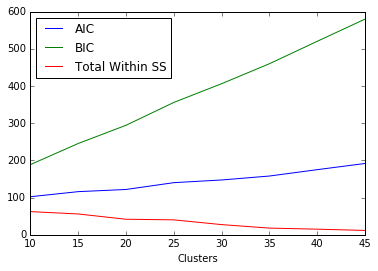

In [166]:
agencia_k_range = range(10, 50, 5)
tic()
cluster_and_plot('Agencia_ID', agencia_k_range)
tac()

It Looks Like Clusters = 20 is a good choice










Time passed: 0hour:0min:4sec


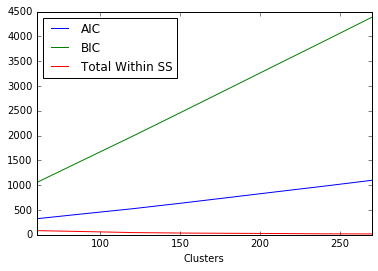

In [167]:
ruta_k_range = range(60, 300, 30)
tic()
cluster_and_plot('Ruta_SAK', ruta_k_range)
tac()

It Looks Like Clusters = 80 is a good choice










Time passed: 0hour:0min:5sec


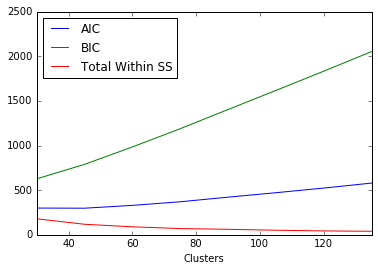

In [168]:
producto_k_range = range(30, 150, 15)
tic()
cluster_and_plot('Producto_ID', producto_k_range)
tac()

It Looks Like Clusters = 45 is a good choice






Time passed: 0hour:1min:53sec


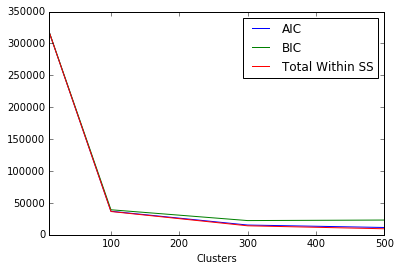

In [169]:
tic()
cliente_k_range = [10,100,300,500]
cluster_and_plot('Cliente_ID', cliente_k_range)
tac()

It looks like 300 or 400 would work

#### Now we the right amount of centroids, we process the clustering and fitting

In [170]:
# --- HYPERPARAMETERS FOR K-MEANS ---

# number of clusters to group depot/route/produc (if 0 will not be added as feature)
num_clusters_agencia = 20
num_clusters_ruta = 80
num_clusters_producto = 45
#num_clusters_cliente is set up at the beggining of this notebook

In [171]:
def cluster_and_save(feat_name, num_clusters):
    '''
    Input: 
        - idx: the index of the feature we want to cluster, one-hot-encode, and add to our features
        - num_clusters: the number of clusters we want to use to group the feature values
    '''   
    global data

    # run clustering by demand using info from week 3-9
    feat = data.loc[:, feat_name]
    tar = data.loc[:, 'pairs_mean']
    feat_tar = pd.concat([feat, tar], axis=1)
        
    # group by feature
    grouped_ft = feat_tar.groupby(feat_name)
    grouped_ft = pd.merge(grouped_ft.median().reset_index(), grouped_ft.std().reset_index(), how='left', on=[feat_name])
    
    demand_info_unique = grouped_ft.iloc[:,1:]
    demand_info_unique[pd.isnull(demand_info_unique)] = 0
    
    # we use the kmeans clustering algorithm
    h2odf = h2o.H2OFrame(demand_info_unique)
    kmeans = H2OKMeansEstimator(k=num_clusters, init="Random", seed=2, standardize=True)

    kmeans.train(x = h2odf.col_names, training_frame = h2odf)
    clusters_h2odf = kmeans.predict(h2odf)
    clustersdf = clusters_h2odf.as_data_frame(True)
    clusters = clustersdf.predict.get_values()
    
    # plot demand/cluster
    plt.figure(figsize=(15, 3))
    for c in range(num_clusters):
        d_median = demand_info_unique.iloc[clusters==c,0]
        d_std = demand_info_unique.iloc[clusters==c,1]
        plt.plot(d_median,d_std,'.')
        plt.xlabel('median')
        plt.ylabel('std')
    plt.savefig("./input-data/h2o-clustByDem_{}_{}".format(feat_name, num_clusters))
    
    # create new dataframe to save the mapping from feature ID to cluster ID
    feat_clust_map = pd.DataFrame(data = grouped_ft.iloc[:,0], columns=[feat_name])
    feat_clust_map.insert(1, feat_name+'_clust_ID', clusters)

    # save the new feature in files for others to use 
    feat_clust_map.to_csv("./input-data/h2o-clustByDem_{}.csv".format(feat_name), index=False)

Agencia Clusters



Time passed: 0hour:0min:3sec


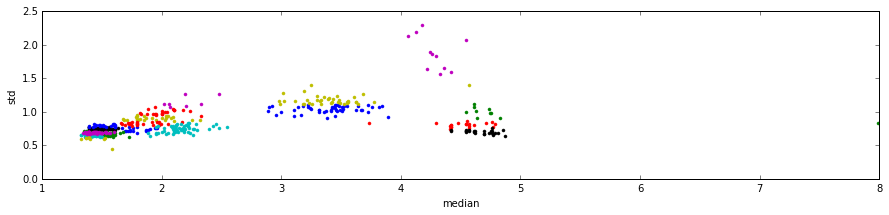

In [172]:
tic()
print("Agencia Clusters")
cluster_and_save('Agencia_ID', num_clusters_agencia)
tac()

Ruta Clusters



Time passed: 0hour:0min:3sec


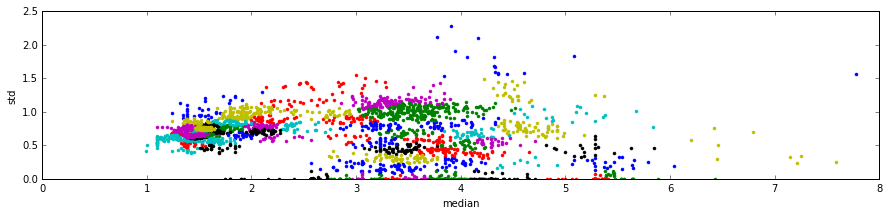

In [173]:
tic()
print("Ruta Clusters")
cluster_and_save('Ruta_SAK', num_clusters_ruta)
tac()

Producto Clusters



Time passed: 0hour:0min:4sec


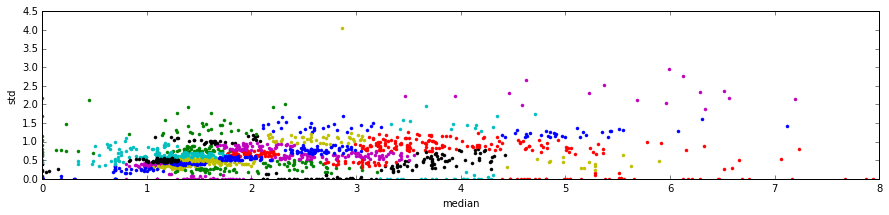

In [174]:
tic()
print("Producto Clusters")
cluster_and_save('Producto_ID', num_clusters_producto)
tac()

Cliente Clusters



Time passed: 0hour:3min:23sec


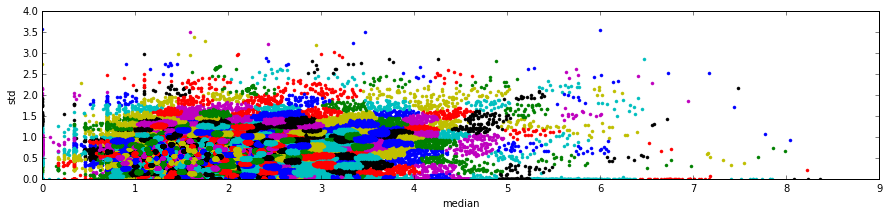

In [175]:
tic()
print("Cliente Clusters")
cluster_and_save('Cliente_ID', num_clusters_cliente)
tac()

In [176]:
#Read files:
agencia_by_dem_clust = pd.read_csv('input-data/h2o-clustByDem_Agencia_ID.csv')
ruta_by_dem_clust = pd.read_csv('input-data/h2o-clustByDem_Ruta_SAK.csv')
prod_by_dem_clust = pd.read_csv('input-data/h2o-clustByDem_Producto_ID.csv')
cliente_by_dem_clust = pd.read_csv('input-data/h2o-clustByDem_Cliente_ID.csv')

In [177]:
data = pd.merge(data, prod_by_dem_clust, on='Producto_ID')
data = pd.merge(data, ruta_by_dem_clust, on='Ruta_SAK')
data = pd.merge(data, agencia_by_dem_clust, on='Agencia_ID')
data = pd.merge(data, cliente_by_dem_clust, on='Cliente_ID')

In [178]:
data.head()

,id,Semana,Agencia_ID,Canal_ID,Ruta_SAK,Cliente_ID,Producto_ID,Demanda_uni_equil,source,ix,...,brand,prodtype_cluster,Qty_Ruta_SAK_Bin,ZipCode,week_ct,NombreCliente,Producto_ID_clust_ID,Ruta_SAK_clust_ID,Agencia_ID_clust_ID,Cliente_ID_clust_ID
0,NaN,7,1110,7,3301,15766,1216,2.0,train,42982034,...,BIM,2,low,2008,3,Post,20,68,5,3745
1,NaN,8,1110,7,3301,15766,1216,5.0,train,53364884,...,BIM,2,low,2008,0,Post,20,68,5,3745
2,924190.0,11,1110,7,3301,15766,1216,NaN,test,75104654,...,BIM,2,low,2008,3,Post,20,68,5,3745
3,NaN,7,1110,7,3301,15766,1238,2.0,train,42982035,...,BIM,2,low,2008,3,Post,20,68,5,3745
4,NaN,8,1110,7,3301,15766,1238,3.0,train,53364886,...,BIM,2,low,2008,0,Post,20,68,5,3745


## Encode nominal features, one-hot Categorical features and Scale numerical features
Since scikit-learn accepts only numerical variables, so i have to convert all categories of nominal variables into numeric types.

Lets start with coding all low cardinality object/nominal categorical variables (brand, Qty_Ruta_SAK_Bin, NombreCliente)  as numeric using ‘LabelEncoder’ from sklearn’s preprocessing module.

In [179]:
print (data.dtypes)

id                      float64
Semana                     int8
Agencia_ID               uint16
Canal_ID                   int8
Ruta_SAK                  int32
Cliente_ID                int32
Producto_ID               int32
Demanda_uni_equil       float64
source                   object
ix                        int64
log_target              float64
pairs_mean              float64
Log_Target_mean_lag1    float64
Log_Target_mean_lag2    float64
Log_Target_mean_lag3    float64
Log_Target_mean_lag4    float64
Lags_sum                float64
brand                    object
prodtype_cluster          int64
Qty_Ruta_SAK_Bin         object
ZipCode                  uint16
week_ct                   int64
NombreCliente            object
Producto_ID_clust_ID      int64
Ruta_SAK_clust_ID         int64
Agencia_ID_clust_ID       int64
Cliente_ID_clust_ID       int64
dtype: object


In [180]:
#data.apply(lambda x: len(x.unique()))

In [181]:
#Here we convert to numbers the nominal variables
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

var_mod = ['brand', 'Qty_Ruta_SAK_Bin', 'NombreCliente']
for i in var_mod:
    data[i] = le.fit_transform(data[i])

In [182]:
data.describe()

,id,Semana,Agencia_ID,Canal_ID,Ruta_SAK,Cliente_ID,Producto_ID,Demanda_uni_equil,ix,log_target,...,brand,prodtype_cluster,Qty_Ruta_SAK_Bin,ZipCode,week_ct,NombreCliente,Producto_ID_clust_ID,Ruta_SAK_clust_ID,Agencia_ID_clust_ID,Cliente_ID_clust_ID
count,6.999251e+06,3.819768e+07,3.819768e+07,3.819768e+07,3.819768e+07,3.819768e+07,3.819768e+07,2.078972e+07,3.819768e+07,2.078972e+07,...,3.819768e+07,3.819768e+07,3.819768e+07,3.819768e+07,3.819768e+07,3.819768e+07,3.819768e+07,3.819768e+07,3.819768e+07,3.819768e+07
mean,3.499625e+06,8.457756e+00,2.523158e+03,1.396291e+00,2.114209e+03,1.810162e+06,2.127470e+04,7.317181e+00,6.208087e+07,1.607684e+00,...,7.673814e+00,1.363295e+01,1.068444e+00,2.253787e+03,1.545032e+00,8.991646e+00,1.926413e+01,4.091755e+01,1.094002e+01,1.989458e+03
std,2.020510e+06,1.233185e+00,4.044778e+03,1.498182e+00,1.491885e+03,2.482712e+06,1.877195e+04,2.184941e+01,1.102672e+07,8.483458e-01,...,8.803684e+00,7.493795e+00,8.202781e-01,1.753312e+02,1.231955e+00,2.868121e+00,1.128353e+01,2.526114e+01,5.236638e+00,1.148501e+03
min,0.000000e+00,7.000000e+00,1.110000e+03,1.000000e+00,1.000000e+00,2.600000e+01,4.100000e+01,0.000000e+00,4.298203e+07,1.396148e-05,...,0.000000e+00,1.000000e+00,0.000000e+00,2.001000e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,NaN,7.000000e+00,1.311000e+03,1.000000e+00,1.157000e+03,3.558090e+05,1.242000e+03,NaN,5.253145e+07,NaN,...,1.000000e+00,9.000000e+00,0.000000e+00,2.070000e+03,0.000000e+00,8.000000e+00,1.200000e+01,1.900000e+01,8.000000e+00,9.930000e+02
50%,NaN,8.000000e+00,1.613000e+03,1.000000e+00,1.281000e+03,1.197348e+06,3.055500e+04,NaN,6.208087e+07,NaN,...,1.000000e+00,1.400000e+01,1.000000e+00,2.269000e+03,1.000000e+00,8.000000e+00,2.000000e+01,4.500000e+01,1.000000e+01,1.997000e+03
75%,NaN,9.000000e+00,2.036000e+03,1.000000e+00,2.802000e+03,2.380320e+06,4.021700e+04,NaN,7.163029e+07,NaN,...,1.300000e+01,1.900000e+01,2.000000e+00,2.384000e+03,3.000000e+00,1.000000e+01,2.400000e+01,6.600000e+01,1.400000e+01,2.974000e+03
max,6.999250e+06,1.100000e+01,2.575900e+04,1.100000e+01,9.991000e+03,2.015152e+09,4.999700e+04,5.000000e+03,8.117971e+07,8.565410e+00,...,3.000000e+01,3.000000e+01,3.000000e+00,3.216000e+03,3.000000e+00,1.500000e+01,4.400000e+01,7.900000e+01,1.900000e+01,3.999000e+03


One-Hot-Coding refers to creating dummy variables, one for each category of a categorical variable. For example, the 'cluster' variable has 30 categories. One hot coding will remove this variable and generate 30 new variables. Each will have binary numbers – 0 (if the category is not present) and 1(if category is present).
Categorical variables are intentionally (for censorship) or implicitly encoded as numerical variables in order to be used as features in any given model.

e.g. [house, car, tooth, car] becomes [0,1,2,1].

This imparts an ordinal property to the variable, i.e. house < car < tooth.

As this is ordinal characteristic is usually not desired, one hot encoding is necessary for the proper representation of the distinct elements of the variable.

-- This can be done using ‘get_dummies’ function of Pandas.


In [184]:
#One Hot Coding of the categorical variables
if (onehot_categoricals):
    tic()
    data = pd.get_dummies(data, columns=['week_ct','prodtype_cluster','Qty_Ruta_SAK_Bin', 'brand', 'NombreCliente','ZipCode'])
    tac()

In [185]:
data.dtypes

id                      float64
Semana                     int8
Agencia_ID               uint16
Canal_ID                   int8
Ruta_SAK                  int32
Cliente_ID                int32
Producto_ID               int32
Demanda_uni_equil       float64
source                   object
ix                        int64
log_target              float64
pairs_mean              float64
Log_Target_mean_lag1    float64
Log_Target_mean_lag2    float64
Log_Target_mean_lag3    float64
Log_Target_mean_lag4    float64
Lags_sum                float64
brand                     int64
prodtype_cluster          int64
Qty_Ruta_SAK_Bin          int64
ZipCode                  uint16
week_ct                   int64
NombreCliente             int64
Producto_ID_clust_ID      int64
Ruta_SAK_clust_ID         int64
Agencia_ID_clust_ID       int64
Cliente_ID_clust_ID       int64
dtype: object

In [186]:
#Scaling of the numerical values
if (scale_numericals):
    from sklearn import preprocessing
    min_max_scaler = preprocessing.MinMaxScaler()
    
    s_cols = ['pairs_mean', 'Lags_sum']
    for i in range(1,lag):
        s_cols.insert(0,'Log_Target_mean_lag{}'.format(i))
        
    data[s_cols] = min_max_scaler.fit_transform(data[s_cols])

## 5\. Exporting Data

In [188]:
#Divide into test and train:

tic()
train = data.loc[data['source']=="train"]
test = data.loc[data['source']=="test"]
if (use_validation):
    val = data.loc[data['source']=="val"]
    val.drop('Demanda_uni_equil',axis=1,inplace=True) # here all Demanda_uni_equil = nan
    # we merge back the val_targets to the val dataset
    val = pd.merge(val,val_target, on='ix') # we add the true Demanda_uni_equil back
    val['log_target'] = np.log1p(val["Demanda_uni_equil"]) # adds the log_target col

#Drop unnecessary columns: note - we are dropping Demanda_uni_equil since we replaced it by log_target
train.drop(['id','Semana','source','ix'],axis=1,inplace=True)
test.drop(['Semana','source','ix'],axis=1,inplace=True)
if (use_validation):
    val.drop(['id','Semana','source','ix'],axis=1,inplace=True)

#Export files as modified versions:
sufix=""
if (use_validation): sufix += "_holdout"
if (scale_numericals): sufix += "_scaled"
if (onehot_categoricals): sufix += "_onehot"
if (shifted_target): sufix += "_shifted"
sufix += "_" + repr(lag) + "lags"
sufix += "_" + repr(num_clusters_cliente) + "clusters"

train.to_csv("./input-data/train_modified"+sufix+".csv", index=False, quoting=csv.QUOTE_NONE)
test.to_csv("./input-data/test_modified"+sufix+".csv", index=False, quoting=csv.QUOTE_NONE)
if (use_validation):
    val.to_csv("./input-data/val_modified"+sufix+".csv", index=False, quoting=csv.QUOTE_NONE)

tac()

Time passed: 0hour:14min:34sec


In [190]:
val.head()

,Agencia_ID,Canal_ID,Ruta_SAK,Cliente_ID,Producto_ID,log_target,pairs_mean,Log_Target_mean_lag1,Log_Target_mean_lag2,Log_Target_mean_lag3,...,prodtype_cluster,Qty_Ruta_SAK_Bin,ZipCode,week_ct,NombreCliente,Producto_ID_clust_ID,Ruta_SAK_clust_ID,Agencia_ID_clust_ID,Cliente_ID_clust_ID,Demanda_uni_equil
0,1110,7,3301,15766,1238,1.098612,0.141565,0.161971,0.128262,0.128334,...,2,1,2008,1,11,20,68,5,3745,2.0
1,1110,7,3301,15766,1240,1.098612,0.204197,0.128262,0.257122,0.000000,...,14,1,2008,1,11,19,68,5,3745,2.0
2,1110,7,3301,15766,1242,0.693147,0.137204,0.080818,0.128262,0.162063,...,25,1,2008,1,11,19,68,5,3745,1.0
3,1110,7,3301,15766,1250,2.397895,0.213940,0.257122,0.317118,0.080864,...,25,1,2008,1,11,24,68,5,3745,10.0
4,1110,7,3301,15766,1309,1.386294,0.196150,0.161971,0.269494,0.227747,...,18,1,2008,1,11,14,68,5,3745,3.0
